In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%autosave 60

Autosaving every 60 seconds


In [290]:
import urllib
import os

months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

for month in months:
    fname=os.getcwd()+f"/yellow_tripdata_2019-{month}.csv"
    url = f'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-{month}.csv'
    urllib.request.urlretrieve(url, fname)

# Identifying Clusters on Taxi Earnings and Pickup Location

- Data: TLC NYC Yellow Taxi Data
- Period: 2019 (1 year)
- External Data: U.S Weekly Gas Cost

In [6]:
# All helper function
def bool_day(day, weekday):
    if day in weekday:
        return 0
    else:
        return 1
    
def remove_outliers(data, att):
    lb = data[att].quantile(q=0.25)-1.5*data[att].quantile()
    ub = data[att].quantile(q=0.75)+1.5*data[att].quantile()
    data = data.loc[data[att]>lb]
    data = data.loc[data[att]<ub]
    return data

def make_ss(data, att, target, sort_att = False):
    
    lst = []
    unique_val_att = np.sort(data[att].unique())
    print(unique_val_att)
    
    for each_val in unique_val_att:
        lst.append(data[data[att]==each_val])
    
    ss = lst[0].describe()[target]
    
    if len(lst)>=2:
        for each_df in lst[1:]:
            ss = pd.concat([ss, each_df.describe()[target]], axis=1)
    
    return ss

def stratify_sample(data, att, n):
    lst_data = []
    unique_att = data[att].unique()
    for each_label in unique_att:
        lst_data.append(data[data[att]==each_label].sample(n=n))
    samples = lst_data[0]
    for each_data in lst_data[1:]:
        samples = pd.concat([samples, each_data])
    return samples

# Preprocessing Stage

In [291]:
data = pd.read_csv('yellow_tripdata_2019-01.csv')

In [303]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [100]:
def main_preprocessing(data, month):
    
    data = data.loc[data['passenger_count']>0, :]
    data = data.loc[data['trip_distance']>0, :]
    data = data.loc[data['fare_amount']>=2.5, :]
    data = data.loc[data['total_amount']>=2.5, :]
    data = data.loc[data['RatecodeID'].isin([1, 2, 3, 4, 5, 6]), :]
    data = data.loc[data['payment_type'].isin([1])]
    
    # jkf rate
    data = data.loc[jkf_rate(data), :]
    # newark rate
    data = data.loc[newark_rate(data), :]
    
    data = clean_date(data, month)
    
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    
    data = feat_engin(data)
    
    data = data.loc[data['tip_amount']>=0]
    data['tip_amount'] = round(data['tip_amount']/data['total_amount'], 2)
    data['misc_amount'] = round((data['tolls_amount']+data['extra'])/data['total_amount'], 2)
    
    data = data[['trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID','fare_amount', 'misc_amount',
            'tip_amount', 'time', 'hour', 'date']]
    
    #data = do_groupby(data)
    
    return data

In [101]:
def jkf_rate(data):
    all_index = data.index
    sliced_data = data[data['RatecodeID']==2]
    index_sliced = sliced_data[sliced_data['fare_amount']!=52].index
    set_index = set(all_index)-set(index_sliced)
    return list(set_index)

def newark_rate(data):
    all_index = data.index
    sliced_data = data[data['RatecodeID']==3]
    index_sliced = sliced_data[sliced_data['fare_amount']<17.5].index
    set_index = set(all_index)-set(index_sliced)
    return list(set_index)

In [102]:
def feat_engin(data):
    
    data['time'] = data['tpep_dropoff_datetime']-data['tpep_pickup_datetime']
    data['time'] = data['time'].apply(lambda x: float(x.seconds/3600))
    data['speed'] = data['trip_distance']/data['time']
    
    data = prep_feat_engin(data)
    
    data['hour'] = data['tpep_pickup_datetime'].apply(lambda x: x.hour)
    
    # later
    #data['day'] = data['tpep_pickup_datetime'].dt.day_name()
    
    return data

In [103]:
def prep_feat_engin(data):
    
    min_time = 0.083
    max_time = 2
    max_speed = 65
    
    data = data.loc[data['time']>min_time, :]
    data = data.loc[data['time']<max_time, :]
    data = data.loc[data['speed']<max_speed, :]
    
    return data

In [104]:
# clean date
def clean_date(data, month):

    year='2019'

    if (int(month)<8 and int(month)%2!=0) or (int(month)>7 and int(month)%2==0):
        date = [i for i in range(1, 32)]
    elif month=='02':
        date = [i for i in range(1, 29)]
    else:
        date = [i for i in range(1, 31)]

    # Extract the date
    data['date'] = data['tpep_pickup_datetime'].apply(lambda x: x.split()[0])
    # clean the date
    lst_date = data['date'].unique()
    lst_date = [i for i in lst_date if i[5:7] == month and i[0:4] == year and int(i[8:]) in date]
    data = data[data['date'].isin(lst_date)]
    
    return data

In [105]:
def do_groupby(data):
    
    data['trip_count']=1
    
    # get the trip frequency
    freq_data = data.groupby(by=['date', 'PULocationID', 'DOLocationID','RatecodeID', 'hour']).sum().reset_index()['trip_count']
    mean_data = data.groupby(by=['date', 'PULocationID', 'DOLocationID','RatecodeID','hour']).mean().reset_index()
    mean_data['trip_count'] = freq_data
    
    # additional feature engineering
    mean_data['fare_per_minute'] = (mean_data['fare_amount'])/(mean_data['time']*60)
    mean_data['fare_distance'] = mean_data['fare_amount']/mean_data['trip_distance']
    mean_data['day'] = pd.to_datetime(mean_data['date']).dt.dayofweek
    
    return mean_data

In [12]:
data = main_preprocessing(data, '04')

NameError: name 'data' is not defined

In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8492977 entries, 0 to 10046187
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   trip_distance    float64
 1   RatecodeID       int64  
 2   PULocationID     int64  
 3   DOLocationID     int64  
 4   fare_amount      float64
 5   tolls_amount     float64
 6   tip_amount       float64
 7   time             float64
 8   fare_per_minute  float64
 9   fare_distance    float64
 10  hour             int64  
 11  date             object 
dtypes: float64(7), int64(4), object(1)
memory usage: 842.4+ MB


In [277]:
grouped_data = do_groupby(data)

In [274]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111972 entries, 0 to 2111971
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   PULocationID     int64  
 2   DOLocationID     int64  
 3   RatecodeID       int64  
 4   hour             int64  
 5   trip_distance    float64
 6   fare_amount      float64
 7   tolls_amount     float64
 8   tip_amount       float64
 9   time             float64
 10  fare_per_minute  float64
 11  fare_distance    float64
 12  trip_count       int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 209.5+ MB


In [278]:
grouped_data

,date,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,fare_amount,tolls_amount,tip_amount,time,fare_per_minute,fare_distance,trip_count
0,2017-04-01,1,1,2,17,21.460,52.00,5.76,0.000,1.194444,0.725581,2.423113,1
1,2017-04-01,3,51,5,12,2.100,9.20,0.00,0.000,0.199722,0.767733,4.380952,1
2,2017-04-01,4,4,1,0,0.820,5.50,0.00,0.000,0.092500,0.990991,6.707317,1
3,2017-04-01,4,4,1,1,0.785,6.00,0.00,0.000,0.106250,0.941176,7.643312,2
4,2017-04-01,4,4,1,3,1.100,6.75,0.00,0.775,0.118194,0.951821,6.136364,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111967,2017-04-30,265,265,5,0,12.300,198.00,0.00,39.650,0.358333,9.209302,16.097561,1
2111968,2017-04-30,265,265,5,3,12.780,63.00,0.00,8.830,0.740833,1.417323,4.929577,2
2111969,2017-04-30,265,265,5,4,10.000,100.00,10.50,0.000,0.192222,8.670520,10.000000,1
2111970,2017-04-30,265,265,5,16,3.020,45.00,12.50,11.560,0.187222,4.005935,14.900662,1


## Gas Preprocessing

The gas data here is used to take into account the taxi trip operational cost due to fuel lost in each trip per miles.
The data is taken from https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EMM_EPM0_PTE_NUS_DPG&f=W, and it appears that on average, a galon of gas could accomodate 18 miles for each taxi.

In [106]:
gas = pd.read_csv('EMM_EPM0_PTE_NUS_DPGw.csv')

In [107]:
def preprocess_gas(data):
    dic_month={'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 
           'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10',
           'Nov':'11', 'Dec':'12'}
    
    data.dropna(inplace = True)
    data['Date'] = data['Date'].apply(lambda x: x.split())
    data['Date'] = data['Date'].apply(lambda x: x[-1]+'-'+dic_month[x[0]]+'-'+x[1][:2])
    data.columns = ['date', 'gas_price']
    
    #data = data[data['date']>'2017']
    #data = data[data['date']<'2018']
    
    data.to_csv(os.getcwd()+'/gas_price.csv', index = False)

In [108]:
def combined_gas(data, gas):
    grouped_data = pd.merge(data, gas, on='date', how = 'outer')
    grouped_data = grouped_data.fillna(method='bfill')
    grouped_data.dropna(inplace = True)
    return grouped_data

In [248]:
preprocess_gas(gas)

In [113]:
gas = pd.read_csv('gas_price.csv')

In [279]:
check = combined_gas(grouped_data, gas)

In [109]:
def clean_fare_distance(data):
    galon_per_miles = 1/18
    data['est_gas_cost'] = galon_per_miles*data['gas_price']
    data['clean_fare_distance'] = data['fare_distance']-data['est_gas_cost']
    data.drop(labels=['est_gas_cost', 'gas_price', 'fare_distance'], axis=1, inplace = True)
    return data

In [280]:
check = clean_fare_distance(check, gas)

In [289]:
check.head()

,date,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,fare_amount,tolls_amount,tip_amount,time,fare_per_minute,trip_count,clean_fare_distance,day
0,2017-04-01,1.0,1.0,2.0,17.0,21.460,52.00,5.76,0.000,1.194444,0.725581,1.0,2.285835,5
1,2017-04-01,3.0,51.0,5.0,12.0,2.100,9.20,0.00,0.000,0.199722,0.767733,1.0,4.243675,5
2,2017-04-01,4.0,4.0,1.0,0.0,0.820,5.50,0.00,0.000,0.092500,0.990991,1.0,6.570039,5
3,2017-04-01,4.0,4.0,1.0,1.0,0.785,6.00,0.00,0.000,0.106250,0.941176,2.0,7.506034,5
4,2017-04-01,4.0,4.0,1.0,3.0,1.100,6.75,0.00,0.775,0.118194,0.951821,2.0,5.999086,5


In [110]:
def first_stage_preprocessing(gas):
    
    months = ["01","02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    #months = ['01']
    for each_month in months:
        
        data = pd.read_csv(f'yellow_tripdata_2019-{each_month}.csv')
        data = main_preprocessing(data, each_month)
        
        grouped_data = do_groupby(data)
        
        # dont need the data anymore, reduce memory ram
        del data
        
        grouped_data = combined_gas(grouped_data, gas)
        grouped_data = clean_fare_distance(grouped_data)
        
        grouped_data.to_feather(f'clean_data_{each_month}.feather')


In [115]:
# run the first stage
first_stage_preprocessing(gas)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:

In [19]:
grouped_data = do_groupby(data)

In [23]:
grouped_data = combined_gas(grouped_data, gas)
grouped_data = clean_fare_distance(grouped_data)

In [26]:
grouped_data.to_feather(f'clean_data_01.feather')

In [125]:
clean = pd.read_feather('clean_data_02.feather')

In [34]:
clean_1 = pd.read_feather('clean_data_01.feather')

In [35]:
clean = pd.concat([clean_1, clean])

In [116]:
def combined_all():
    months = ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    
    concat_data = pd.read_feather(f"clean_data_01.feather")
    
    for each_month in months:
        data = pd.read_feather(f"clean_data_{each_month}.feather")
        concat_data = pd.concat([concat_data, data])
    
    concat_data.reset_index(inplace = True)
    concat_data.to_feather('clean_all_data.feather')    

In [117]:
combined_all()

# Done Preprocessing

# Descriptive Analysis - Unsupervised

Attribute of Interest for Unsupervised:
- rate/distance
- rate/minute
- trip frequency
- tip%
- misc%

In [36]:
fin_data = pd.read_feather('clean_all_data.feather')

In [37]:
fin_data.head()

,index,date,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,fare_amount,misc_amount,tip_amount,time,trip_count,fare_per_minute,day,clean_fare_distance
0,0,2019-01-01,3.0,51.0,1.0,10.0,1.27,7.00,0.00,0.00,0.121389,1.0,0.961098,1.0,5.382422
1,1,2019-01-01,3.0,61.0,5.0,10.0,21.09,54.84,0.09,0.00,0.603056,1.0,1.515615,1.0,2.470896
2,2,2019-01-01,4.0,4.0,1.0,4.0,1.10,6.50,0.05,0.17,0.109722,1.0,0.987342,1.0,5.779702
3,3,2019-01-01,4.0,7.0,1.0,2.0,9.61,31.00,0.01,0.17,0.471389,1.0,1.096052,1.0,3.096418
4,4,2019-01-01,4.0,7.0,1.0,7.0,7.02,22.00,0.00,0.08,0.353056,1.0,1.038552,1.0,3.004514


In [4]:
fin_data.drop(labels='index', axis=1, inplace = True)

In [131]:
fin_data.shape

(17156376, 14)

In [236]:
# seperate the day into weekday and weekend
weekday = list(range(0, 5))
fin_data['day'] = fin_data['day'].apply(lambda x: bool_day(x, weekday))

In [83]:
fin_data.describe()

,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,fare_amount,tolls_amount,tip_amount,time,trip_count,fare_per_minute,day,clean_fare_distance
count,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07,2.063684e+07
mean,1.525281e+02,1.475645e+02,1.090609e+00,1.318944e+01,4.824380e+00,1.858997e+01,6.339847e-01,2.740115e+00,3.282319e-01,3.391610e+00,9.546837e-01,2.922153e-01,4.881451e+00
std,6.853762e+01,7.467514e+01,4.635615e-01,6.678170e+00,4.714431e+00,6.057933e+01,2.396552e+00,3.135575e+00,2.104992e-01,5.098186e+00,2.645088e+00,4.547807e-01,3.859917e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e-02,2.500000e+00,0.000000e+00,0.000000e+00,8.305556e-02,1.000000e+00,2.130379e-02,0.000000e+00,-4.099573e-02
25%,1.000000e+02,8.700000e+01,1.000000e+00,8.000000e+00,1.748333e+00,9.333333e+00,0.000000e+00,9.200000e-01,1.755903e-01,1.000000e+00,7.721152e-01,0.000000e+00,3.431696e+00
50%,1.450000e+02,1.450000e+02,1.000000e+00,1.400000e+01,3.123333e+00,1.400000e+01,0.000000e+00,2.000000e+00,2.738426e-01,2.000000e+00,8.823529e-01,0.000000e+00,4.262834e+00
75%,2.290000e+02,2.290000e+02,1.000000e+00,1.900000e+01,5.930000e+00,2.250000e+01,0.000000e+00,3.650000e+00,4.175000e-01,4.000000e+00,1.029263e+00,1.000000e+00,5.410486e+00
max,2.650000e+02,2.650000e+02,6.000000e+00,2.300000e+01,1.206000e+02,2.077630e+05,3.288000e+03,1.624640e+03,1.999722e+00,4.080000e+02,9.975282e+03,1.000000e+00,8.147554e+04


By looking at the describe table above, it can be seen that there are extreme outliers identified in the clean fare distance and the fare per minute, as the max are \\$8000 and \\$9975 respectively; thus, these points needs to be excluded

In [245]:
# get sample data for plot
sample_data = fin_data.sample(n=1000)

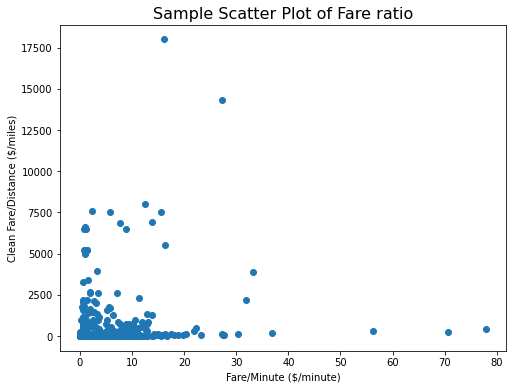

In [104]:
plt.figure(figsize=(8, 6))
plt.scatter(x=sample_data['fare_per_minute'], y=sample_data['clean_fare_distance'])
plt.title('Sample Scatter Plot of Fare ratio', fontsize=16)
plt.ylabel('Clean Fare/Distance ($/miles)')
plt.xlabel('Fare/Minute ($/minute)')
plt.savefig('scatter_')
#plt.show()

The graph above shows that some points are an extreme outliers. This may not be good for our unsupervised clustering, as it may pull the cluster

In [7]:
# remove outliers based on the fare amount ratio
fin_data = remove_outliers(fin_data, 'fare_per_minute')
fin_data = remove_outliers(fin_data, 'clean_fare_distance')

In [134]:
fin_data.describe()

,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,fare_amount,misc_amount,tip_amount,time,trip_count,fare_per_minute,day,clean_fare_distance
count,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07,1.698079e+07
mean,1.540697e+02,1.489724e+02,1.080273e+00,1.344853e+01,4.638676e+00,1.783922e+01,6.382512e-02,1.467774e-01,3.239407e-01,3.002127e+00,9.245129e-01,2.853685e-01,4.652567e+00
std,6.824666e+01,7.406992e+01,4.285380e-01,6.589616e+00,4.589951e+00,1.289387e+01,6.001312e-02,4.981317e-02,2.087606e-01,4.175548e+00,2.343821e-01,4.515898e-01,1.550854e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.700000e-01,2.500000e+00,-3.600000e-01,0.000000e+00,8.305556e-02,1.000000e+00,3.302146e-02,0.000000e+00,-1.805229e-02
25%,1.070000e+02,8.800000e+01,1.000000e+00,9.000000e+00,1.700000e+00,9.083333e+00,1.000000e-02,1.300000e-01,1.733333e-01,1.000000e+00,7.678883e-01,0.000000e+00,3.488346e+00
50%,1.480000e+02,1.460000e+02,1.000000e+00,1.400000e+01,2.960000e+00,1.350000e+01,5.000000e-02,1.651429e-01,2.688889e-01,2.000000e+00,8.742887e-01,0.000000e+00,4.338937e+00
75%,2.300000e+02,2.290000e+02,1.000000e+00,1.900000e+01,5.600000e+00,2.150000e+01,1.000000e-01,1.700000e-01,4.115278e-01,3.000000e+00,1.012536e+00,1.000000e+00,5.480343e+00
max,2.650000e+02,2.650000e+02,6.000000e+00,2.300000e+01,1.055500e+02,2.535000e+02,9.800000e-01,9.800000e-01,1.999722e+00,3.200000e+02,2.328612e+00,1.000000e+00,1.201684e+01


In [8]:
# there is also some negative values, hence, this should be sliced
fin_data = fin_data[fin_data['fare_per_minute']>0]
fin_data = fin_data[fin_data['clean_fare_distance']>0]
fin_data = fin_data[fin_data['misc_amount']>=0]

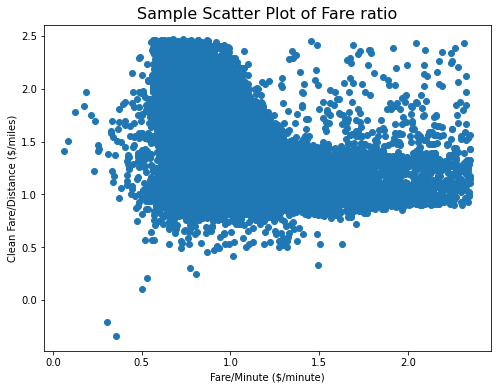

In [110]:
# get sample data for plot
sample_data = fin_data.sample(n=100000)
plt.figure(figsize=(8, 6))
plt.scatter(x=sample_data['fare_per_minute'], y=np.log(sample_data['clean_fare_distance']))
plt.title('Sample Scatter Plot of Fare ratio', fontsize=16)
plt.ylabel('Clean Fare/Distance ($/miles)')
plt.xlabel('Fare/Minute ($/minute)')
plt.show()

From the above plot, both ratio may not have a linear relationship. This may be due to the rules defined by the government regarding to the standard meter, where when the vehicle speed is below 12 mph, then the passenger will be charged 50 cents per minute, but if the speed is above 12 mph, then 50 cents per miles.

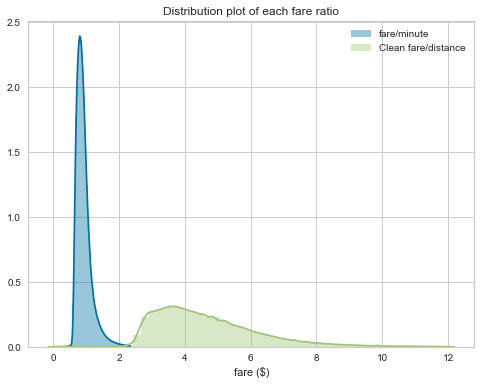

In [136]:
plt.figure(figsize=(8, 6))
sns.distplot(fin_data['fare_per_minute'], label='fare/minute')
sns.distplot(fin_data['clean_fare_distance'], label='Clean fare/distance')
plt.legend()
plt.title('Distribution plot of each fare ratio')
plt.xlabel('fare ($)')
plt.show()

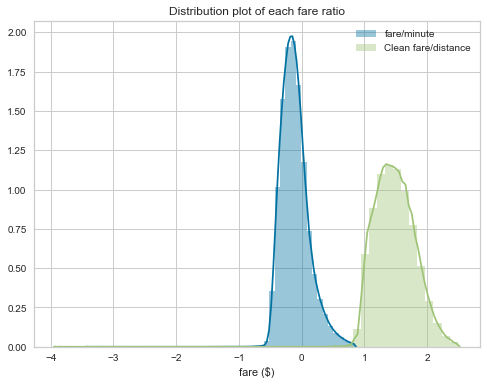

In [137]:
plt.figure(figsize=(8, 6))
sns.distplot(np.log(fin_data['fare_per_minute']), label='fare/minute')
sns.distplot(np.log(fin_data['clean_fare_distance']), label='Clean fare/distance')
plt.legend()
plt.title('Distribution plot of each fare ratio')
plt.xlabel('fare ($)')
plt.show()

### Trip Frequency

In [159]:
# check how many trip count is below 5
count = fin_data[fin_data['trip_count']<5].shape[0]
print(f'Hourly Trip frequency below 5: {count}')

Hourly Trip frequency below 5: 14027366


As you can see, most hourly trip below 5 dominates the population; hence, it is expected that the distribution is potively skewed. Plotting the hourly trip frequency will be log normalised

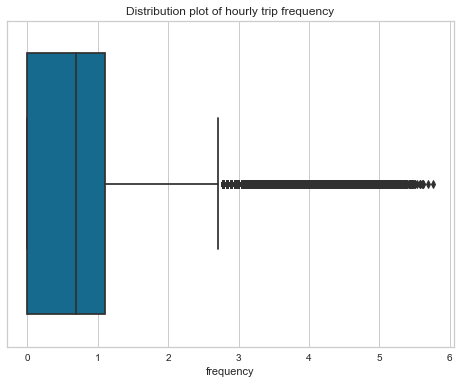

In [160]:
plt.figure(figsize=(8, 6))
sns.boxplot(np.log(fin_data['trip_count']))
plt.title('Distribution plot of hourly trip frequency')
plt.xlabel('frequency')
plt.show()

In [23]:
daily = fin_data.groupby(by=['date', 'PULocationID', 'DOLocationID']).sum().reset_index()

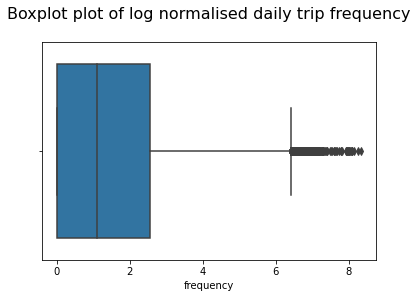

In [27]:
plt.figure()
sns.boxplot(np.log(daily['trip_count']))
plt.title('Boxplot plot of log normalised daily trip frequency\n', fontsize=16)
plt.xlabel('frequency')
plt.show()

From both of these plots, it can be seen that there are several pickup location id that has a huge trip frequency compared to the others, and these are the one that is located in the outliers from both of these boxplot

Examine relationship between fare/distance and fare/time

In [30]:
sample_data = fin_data.sample(n=1000)

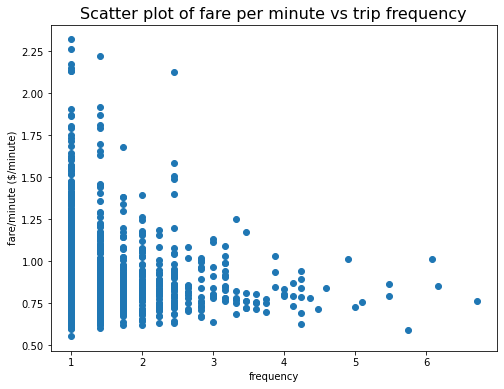

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(y=sample_data['fare_per_minute'], x=np.sqrt(sample_data['trip_count']))
plt.title('Scatter plot of fare per minute vs trip frequency', fontsize=16)
plt.ylabel('fare/minute ($/minute)')
plt.xlabel('frequency')
plt.show()

In [34]:
np.exp(8)

2980.9579870417283

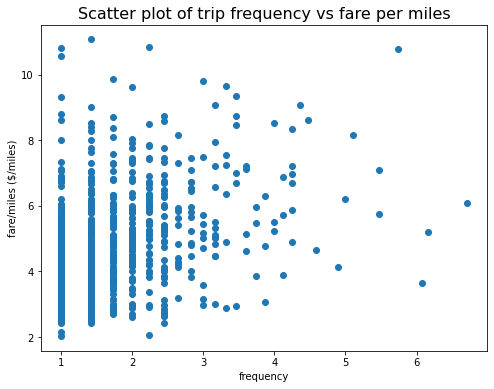

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y=sample_data['clean_fare_distance'], x=np.sqrt(sample_data['trip_count']))
plt.title('Scatter plot of trip frequency vs fare per miles', fontsize=16)
plt.ylabel('fare/miles ($/miles)')
plt.xlabel('frequency')
plt.show()

In [ ]:
# plotting this will give error in VM, need to plot it locally :(
plt.figure(figsize=(8, 6))
plt.scatter(y=sample_data['fare_per_minute'], x=np.sqrt(sample_data['trip_count']))
plt.title('Scatter plot of trip count vs fare per minute', fontsize=16)
plt.ylabel('fare/minute ($/minute)')
plt.xlabel('frequency')
plt.show()

From both of these graph, it can be seen that high trip frequency usually have low fare/minute and fare/distance, which may indicate may it is a famous trip.

### Tip % and Misc %

In [239]:
fin_data[['tip_amount', 'misc_amount']].describe()

,tip_amount,misc_amount
count,1.698075e+07,1.698075e+07
mean,1.467774e-01,6.382542e-02
std,4.981317e-02,6.001246e-02
min,0.000000e+00,0.000000e+00
25%,1.300000e-01,1.000000e-02
50%,1.651429e-01,5.000000e-02
75%,1.700000e-01,1.000000e-01
max,9.800000e-01,9.800000e-01


It can be seen that the distribution is positively skewed as well, as the difference between q2 and the maximum for both attribute is huge; hence, these outliers should be removed.

In [9]:
fin_data = remove_outliers(fin_data, 'tip_amount')
fin_data = remove_outliers(fin_data, 'misc_amount')

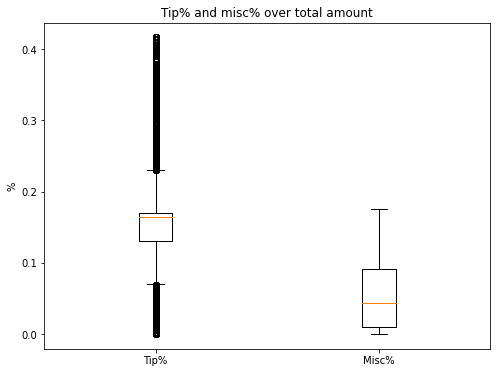

In [11]:
# Create a figure instance
fig = plt.figure(1, figsize=(8, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([fin_data['tip_amount'], fin_data['misc_amount']])
ax.set_xticklabels(['Tip%', 'Misc%'])
plt.ylabel('%')

plt.title('Tip% and misc% over total amount')
plt.show()

In [ ]:
sample_data = fin_data.sample(n=1000)

## Model

### Unsupervised

In [97]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
#from sklearn.decisiontreeclassifier import
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
# linear regression pake statsmodel aja

### K-means Clustering

In [98]:
# the outliers for the fare has been removed, trip frequency will not be checked for outliers, as it is based on 
# recorded trips
fin_data = remove_outliers(fin_data, 'tip_amount')

In [99]:
fin_data.shape

(16970582, 15)

In [162]:
fin_data.head()

,index,date,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,fare_amount,tolls_amount,tip_amount,time,trip_count,fare_per_minute,day,clean_fare_distance,tolls_block
0,0,2019-01-01,3.0,51.0,1.0,10.0,1.27,7.00,0.00,0.00,0.121389,1.0,0.961098,0,5.382422,0
1,1,2019-01-01,3.0,61.0,5.0,10.0,21.09,54.84,5.76,0.00,0.603056,1.0,1.515615,0,2.470896,1
2,2,2019-01-01,4.0,4.0,1.0,4.0,1.10,6.50,0.00,0.17,0.109722,1.0,0.987342,0,5.779702,0
3,3,2019-01-01,4.0,7.0,1.0,2.0,9.61,31.00,0.00,0.17,0.471389,1.0,1.096052,0,3.096418,0
4,4,2019-01-01,4.0,7.0,1.0,7.0,7.02,22.00,0.00,0.08,0.353056,1.0,1.038552,0,3.004514,0


In [161]:
fin_data.reset_index(inplace = True)

#### Cluster evaluatoin for fare per minute, fare per distance, tip amount percentage and trip frequency

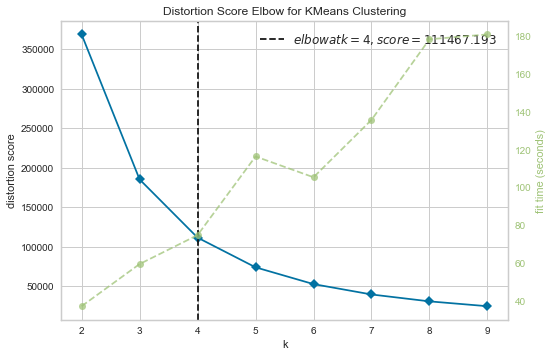

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [14]:
arr = np.reshape(fin_data['fare_per_minute'].values, (fin_data.shape[0], 1))
kelbow_visualizer(KMeans(random_state=42), arr, k=(2,10))

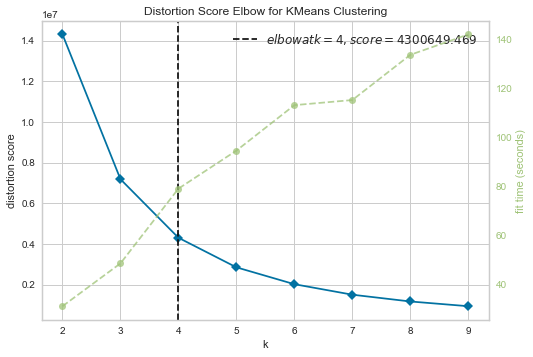

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [15]:
arr = np.reshape(fin_data['clean_fare_distance'].values, (fin_data.shape[0], 1))
kelbow_visualizer(KMeans(random_state=42), arr, k=(2,10))

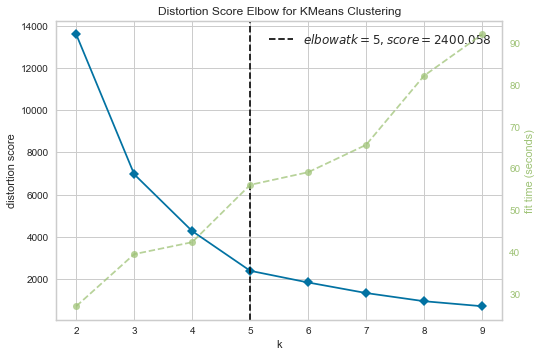

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [16]:
arr = np.reshape(fin_data['tip_amount'].values, (fin_data.shape[0], 1))
kelbow_visualizer(KMeans(random_state=42), arr, k=(2,10))

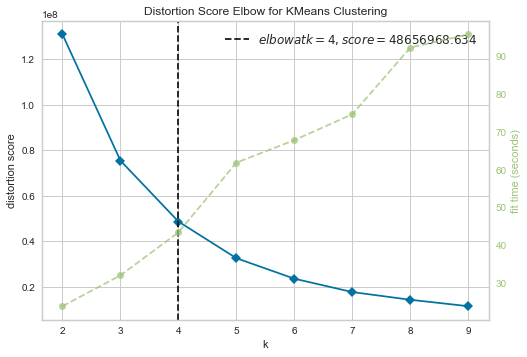

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [17]:
arr = np.reshape(fin_data['trip_count'].values, (fin_data.shape[0], 1))
kelbow_visualizer(KMeans(random_state=42), arr, k=(2,10))

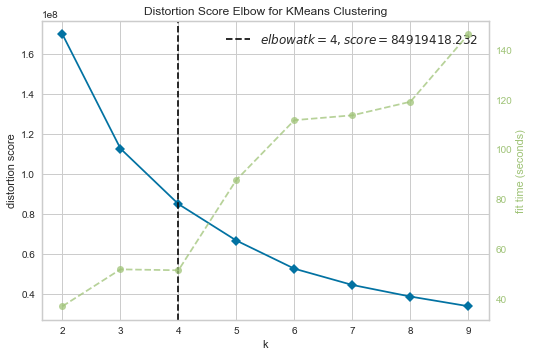

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [19]:
arr = fin_data[['trip_count', "tip_amount", "clean_fare_distance", "fare_per_minute", "misc_amount"]]
kelbow_visualizer(KMeans(random_state=42), arr, k=(2,10))

In [ ]:
# the result of k here is 4, VM autosave error, lost the graph :(
arr = np.reshape(fin_data['misc_amount'].values, (fin_data.shape[0], 1))
kelbow_visualizer(KMeans(random_state=42), arr, k=(2,10))

The result using the elbow method show that there may be 4 natural group, and 4 group in trip frequency, fare rate, and 5 group in tip amount. The analysis will be split into 2 model, one with unsupervised equal width binning and manual labeling based on the each att bin classes, the other is the natural group from these 4 core attributes, using k-means

In [211]:
arr = fin_data[['trip_count', "tip_amount", "clean_fare_distance", "fare_per_minute", "misc_amount"]]

#### Equal Width Binning

In [204]:
def binning(data, att):
    for attribute, k in att:
        name = f"{attribute}_block"
        blocks = list(np.linspace(min(data[attribute].values), max(data[attribute].values), k+1))
        data[name] = pd.cut(data[attribute].values, blocks, labels=list(range(1, k+1)), include_lowest = True)
    return data

In [212]:
arr = binning(arr, [['trip_count', 4], ['tip_amount', 5], ['clean_fare_distance', 4], 
                    ['fare_per_minute', 4], ['misc_amount', 4]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [213]:
for each_block in arr.columns[5:]:
    arr[each_block] = arr[each_block].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [214]:
arr['score'] = arr['trip_count_block']+arr['tip_amount_block']+arr['clean_fare_distance_block']+arr['fare_per_minute_block']+arr['misc_amount_block']
arr.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,trip_count,tip_amount,clean_fare_distance,fare_per_minute,misc_amount,trip_count_block,tip_amount_block,clean_fare_distance_block,fare_per_minute_block,misc_amount_block,score
0,1.0,0.00,5.382422,0.961098,0.00,1,1,2,2,1,7
1,1.0,0.00,2.470896,1.515615,0.09,1,1,1,3,3,9
2,1.0,0.17,5.779702,0.987342,0.05,1,3,2,2,2,10
3,1.0,0.17,3.096418,1.096052,0.01,1,3,2,2,1,9
4,1.0,0.08,3.004514,1.038552,0.00,1,1,1,2,1,6


In [215]:
arr['score'].describe()

count    1.607850e+07
mean     9.449215e+00
std      1.325737e+00
min      5.000000e+00
25%      9.000000e+00
50%      9.000000e+00
75%      1.000000e+01
max      1.800000e+01
Name: score, dtype: float64

To make both model comparable, this equal binning will be split into 4 ratings as well

In [216]:
arr = binning(arr, [['score', 4]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [217]:
arr['score_block'].value_counts()

2    11437350
1     3464923
3     1173877
4        2355
Name: score_block, dtype: int64

Here, we can see that the distribution is not equal, as most is in score block 2, and much less in 4. Hence, the best way to label them in strings are 1: poor, 2: standard, 3: good, 4: rare

#### K-means binning

In [218]:
data_k_means = arr[['trip_count', 'tip_amount', 'clean_fare_distance', 'fare_per_minute', 'misc_amount']].copy()
scaler = MinMaxScaler()
data_k_means = scaler.fit_transform(data_k_means[data_k_means.columns])
arr_kmeans = KMeans(n_clusters=4, random_state=42).fit(data_k_means)

In [219]:
label_pred = arr_kmeans.predict(data_k_means)

In [220]:
arr_kmeans.cluster_centers_

array([[1.16784696e-02, 3.71471011e-01, 4.37101537e-01, 3.57565806e-01,
        3.96753465e-01],
       [6.89671750e-04, 1.16977219e-01, 3.35689993e-01, 4.03343732e-01,
        8.40650329e-02],
       [7.48534098e-03, 3.46858707e-01, 3.69707774e-01, 4.09452334e-01,
        7.33780690e-01],
       [3.54709127e-03, 4.02198480e-01, 3.65554285e-01, 3.90603717e-01,
        7.57831474e-02]])

In [221]:
arr['score_block_kmeans'] = label_pred
arr['score_block_kmeans'] = arr['score_block_kmeans']+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [222]:
arr['score_block_kmeans'].value_counts()

4    6226875
1    4655823
3    3613913
2    1581894
Name: score_block_kmeans, dtype: int64

Here, the group is much different. It can be seen that most are labeled as 4, while the least one is at 3. But, the group is much more distributed, compared to the manual labelling. Thus, the next step is to evaluate both of these group.